# DATA SCIENCE SESSIONS VOL. 3
### A Foundational Python Data Science Course
## Tasklist 19: Generalized Linear Models IV. Poisson Regression. Negative Binomial Regression. 

[&larr; Back to course webpage](https://datakolektiv.com/)

Feedback should be send to [goran.milovanovic@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com). 

These notebooks accompany the DATA SCIENCE SESSIONS VOL. 3 :: A Foundational Python Data Science Course.

![](../img/IntroRDataScience_NonTech-1.jpg)

### Lecturers

[Goran S. Milovanović, PhD, DataKolektiv, Chief Scientist & Owner](https://www.linkedin.com/in/gmilovanovic/)

[Aleksandar Cvetković, PhD, DataKolektiv, Consultant](https://www.linkedin.com/in/alegzndr/)

[Ilija Lazarević, MA, DataKolektiv, Consultant](https://www.linkedin.com/in/ilijalazarevic/)

![](../img/DK_Logo_100.png)

***

In this tasklist you'll get to practice Poisson and Negative Binomial Regression some more. Everything you need to know for this tasklist is already laid out in Session19 notebook, so you can dive in right away.

In [1]:
### --- Setup - importing the libraries

# - supress those annoying 'Future Warning'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# - data
import numpy as np
import pandas as pd

# - os
import os

# - ml
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import statsmodels.api as sm
import statsmodels.formula.api as smf

# - visualization
import matplotlib.pyplot as plt
import seaborn as sns

# - parameters
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
sns.set_theme()

# - rng
rng = np.random.default_rng(1234)

# - plots
plt.rc("figure", figsize=(8, 6))
plt.rc("font", size=14)
sns.set_theme(style='white')

# - directory tree
data_dir = os.path.join(os.getcwd(), '_data')

We'll take a look at `Household Size in the Philippines` dataset, taken from the book [Beyond Multiple Linear Regression: Applied Generalized Linear Models and Multilevel Models in R, Paul Roback and Julie Legler](https://bookdown.org/roback/bookdown-BeyondMLR/); the dataset can be downloaded [here](https://github.com/proback/BeyondMLR), and you can also find it as `fHH1.csv` file in `_data` folder.

In [2]:
df = pd.read_csv(os.path.join(data_dir, "fHH1.csv"))
df

,location,age,total,numLT5,roof
0,CentralLuzon,65,0,0,Predominantly Strong Material
1,MetroManila,75,3,0,Predominantly Strong Material
2,DavaoRegion,54,4,0,Predominantly Strong Material
3,Visayas,49,3,0,Predominantly Strong Material
4,MetroManila,74,3,0,Predominantly Strong Material
...,...,...,...,...,...
1495,Visayas,37,2,0,Predominantly Strong Material
1496,MetroManila,45,3,1,Predominantly Strong Material
1497,MetroManila,34,4,1,Predominantly Strong Material
1498,IlocosRegion,58,3,0,Predominantly Strong Material


What we would like to do is to be able to predict the total variable, which represents the number of people living in a household (other than the head of the household), from the following covariates:

- `location`: where the house is located (regions in the Philippines, whose The Philippine Statistics Authority (PSA) spearheads from the Family Income and Expenditure Survey (FIES) are the source of this dataset);
- `age`: the age of the head of household;
- `numLT5`: the number of people in the household under 5 years of age;
- `roof`: the type of roof in the household (either Predominantly Light/Salvaged Material, or Predominantly Strong Material: stronger material can sometimes be used as a proxy for greater wealth).

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   location  1500 non-null   object
 1   age       1500 non-null   int64 
 2   total     1500 non-null   int64 
 3   numLT5    1500 non-null   int64 
 4   roof      1500 non-null   object
dtypes: int64(3), object(2)
memory usage: 58.7+ KB


As we can see, the dataset does not contain missing values, and the types of variables are consistent with their definitions; so, no need for cleaning this dataset. 

**01.** Make a countplot showing the counts of every value present in the `total` variable. What distribution does this chart resemble?

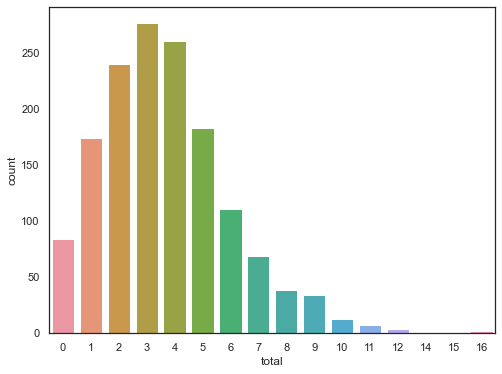

In [4]:
sns.countplot(df['total']);

**02.** Perform one-hot encoding of every categorical predictor in the dataset.

In [5]:
df = pd.get_dummies(df, columns=['location', 'roof'], drop_first=True)
df

,age,total,numLT5,location_DavaoRegion,location_IlocosRegion,location_MetroManila,location_Visayas,roof_Predominantly Strong Material
0,65,0,0,0,0,0,0,1
1,75,3,0,0,0,1,0,1
2,54,4,0,1,0,0,0,1
3,49,3,0,0,0,0,1,1
4,74,3,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...
1495,37,2,0,0,0,0,1,1
1496,45,3,1,0,0,1,0,1
1497,34,4,1,0,0,1,0,1
1498,58,3,0,0,1,0,0,1


**03.** 

**a)** Using `statsmodels` fit Poisson Regression on the given data to predict values of `total` variable from the rest of the variables. 

In [6]:
# X, y
X = df.drop('total', axis=1)
y = df['total']

In [7]:
# Add a constant to the independent variable matrix
X1 = sm.add_constant(X)

# Fit a Poisson regression model
poisson_model = sm.GLM(y, X1, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  total   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1492
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3135.4
Date:                Sun, 28 May 2023   Deviance:                       1897.9
Time:                        23:59:00   Pearson chi2:                 1.76e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

**b)** Take the exponentials of model coefficients and interpret the values.

In [8]:
np.exp(poisson_results.params)

const                                 2.890241
age                                   0.999774
numLT5                                1.439566
location_DavaoRegion                  0.955113
location_IlocosRegion                 1.009072
location_MetroManila                  1.038876
location_Visayas                      1.049838
roof_Predominantly Strong Material    1.061533
dtype: float64

In Poisson regression, taking the exponentiation of the coefficients (e.g. $e^{\beta_1}$) provides the expected count ratio associated with each independent variable. It quantifies the **multiplicative effect on the expected count of events** for a one-unit increase in the corresponding independent variable, assuming all other variables are held constant.

**c)** Compute AIC of the model. 

In [9]:
# AIC = -2 * LL + 2 * k
ll = poisson_results.llf
k = X1.shape[1]
aic = -2*ll + 2*k
print(f'AIC: {aic}')

AIC: 6286.755454462616


**d)** Is there overdispersion in the model?

In [10]:
# To test for overdispersion, we calculate the ratio of the deviance to the degrees of freedom
# If this ratio is significantly greater than 1, it indicates overdispersion
ratio = poisson_results.deviance / poisson_results.df_resid
print('Ratio of Deviance to Degrees of Freedom: ', ratio)

Ratio of Deviance to Degrees of Freedom:  1.272034853614132


**04.** 

**a)** Use `scikit-learn` to fit Poisson Regression on the given data to predict values of `total` variable from the rest of the variables. Do not perform regularization.

In [11]:
# X, y
X = df.drop('total', axis=1)
y = df['total']

# Create a pipeline for preprocessing and Poisson Regression
pipeline = Pipeline([
    ('regressor', PoissonRegressor(alpha=0, max_iter=10000))
])

# Fit L2 regularized Poisson regression model
pipeline.fit(X, y)

Pipeline(steps=[('regressor', PoissonRegressor(alpha=0, max_iter=10000))])

In [12]:
# this gives non-integer values
pipeline.predict(X)

array([3.02336214, 3.13388266, 2.89492611, ..., 4.5533608 , 3.05560153,
       3.04184862])

In [13]:
# but we need integer values, so we round

pipeline.predict(X).round()

array([3., 3., 3., ..., 5., 3., 3.])

**b)** What's $D^2$ score of the model?

In [14]:
# How good is the model?
d2 = pipeline.score(X,y)
print("D2 = ", d2)

D2 =  0.1966621930352931


**05.** Using `scikit-learn` and cross-validation, fit Poisson Regression with $L_2$ regularization. Calculate AIC and $D^2$ score of the optimally regularized model.

In [15]:
# Create a pipeline for preprocessing and Poisson Regression
pipeline = Pipeline([
    ('regressor', PoissonRegressor(max_iter=10000))
])

# Define the parameter grid for tuning
param_grid = {
    'regressor__alpha': [0, .01 , .1, .25, .5, .75, 1, 2, 5, 10, 20, 50, 100] 
}

# Create a cross-validation strategy
cv = KFold(n_splits=5)

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=param_grid, 
                           cv=cv)
grid_search.fit(X, y)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'regressor__alpha': 0.1}
Best Score:  0.18854127084119318


In [16]:
# optimal alpha
l2_penalty = grid_search.best_params_['regressor__alpha']

# Create a pipeline for preprocessing and Poisson Regression
pipeline = Pipeline([
    ('regressor', PoissonRegressor(alpha=l2_penalty, max_iter=10000))
])

# Fit L2 regularized Poisson regression model
pipeline.fit(X, y)

# Grab model
optimal_model = pipeline.named_steps['regressor']

# Print the exp(coefficients)
coefficients = optimal_model.coef_
exp_coefficients = np.exp(optimal_model.coef_)
intercept = optimal_model.intercept_
exp_intercept = np.exp(optimal_model.intercept_)
print("Intercept:", intercept)
print("Coefficients:", coefficients)
print("exp(Intercept):", exp_intercept)
print("exp(Coefficients):", exp_coefficients)

# How good is the model?
d2 = optimal_model.score(X,y)
print("D2 = ", d2)

Intercept: 1.0968796525318354
Coefficients: [-0.00040866  0.3500844  -0.04146293  0.00373767  0.02945356  0.0418979
  0.04528022]
exp(Intercept): 2.994806592033563
exp(Coefficients): [0.99959143 1.41918733 0.9593849  1.00374466 1.02989161 1.04278801
 1.04632102]
D2 =  0.19625557144657058


`scikit-learn` does not have a support for easy calculation of AIC as `statsmodels` has. A way to find AIC score would be to fit the Regularized Poisson Regression Model with optimal $\alpha$ via `statsmodels` `.fit_regularized()`. Unfortunately, this option supports only Elastic-Net Regularization, and not $L_2$ - as we did in this task. 

**06.** Using `statsmodels` fit Negative Binomial Regression. Compute AIC and $D^2$ score of this model. Is there some significant improvement over Poisson Regression model? Why?

In [17]:
from statsmodels.discrete.discrete_model import NegativeBinomial

# Fit the negative binomial regression model
model = NegativeBinomial(endog=y, exog=X1)
res = model.fit()

# Print the model summary
print(res.summary())

Optimization terminated successfully.
         Current function value: 2.085137
         Iterations: 24
         Function evaluations: 31
         Gradient evaluations: 31
                     NegativeBinomial Regression Results                      
Dep. Variable:                  total   No. Observations:                 1500
Model:               NegativeBinomial   Df Residuals:                     1492
Method:                           MLE   Df Model:                            7
Date:                Sun, 28 May 2023   Pseudo R-squ.:                 0.05238
Time:                        23:59:10   Log-Likelihood:                -3127.7
converged:                       True   LL-Null:                       -3300.6
Covariance Type:            nonrobust   LLR p-value:                 9.827e-71
                                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [18]:
# AIC = -2 * LL + 2 * k
ll = res.llf
k = X1.shape[1]
aic = -2*ll + 2*k
print(f'AIC: {aic}')

AIC: 6271.409922193197


In [19]:
def calculate_dev(y_true,y_pred, scalar=False):
    if not scalar:
        score = np.zeros(y_true.size)
        y0 = np.where(y_true==0)[0]
        yn0 = np.where(y_true!=0)[0]
        score[y0] = 2*(0 - (y_true[y0]-y_pred[y0]))
        print(score[y0].sum())
        score[yn0] = 2*(y_true[yn0] * np.log(y_true[yn0]/y_pred[yn0]) - (y_true[yn0]-y_pred[yn0]))
        print(score[yn0].sum())
        return(score.sum())
    else:
        score = np.zeros(y_true.size)
        y0 = np.where(y_true==0)[0]
        yn0 = np.where(y_true!=0)[0]
        score[y0] = 2*(0 - (y_true[y0]-y_pred))
        score[yn0] = 2*(y_true[yn0] * np.log(y_true[yn0]/y_pred) - (y_true[yn0]-y_pred))
        return(score.sum())

res_deviance = calculate_dev(y, res.predict())
null_deviance = calculate_dev(y, np.mean(y), scalar=True)
print(f'Residual Deviance: {res_deviance}')
print(f'Null Deviance: {null_deviance}')
d2 = 1-(res_deviance/null_deviance)
print(f'D2: {d2}')

512.5990351849497
1385.5307499368441
Residual Deviance: 1898.1297851217937
Null Deviance: 2362.4880915998583
D2: 0.19655477127235166


There isn't some significant improvement over Poisson Regression Model, as can be seen by comparing the two AIC scores. This is because there's not big overdispersion in the given data, as it can be seen from the `alpha` coefficient of the Negative Binomial Regression.

DataKolektiv, 2022/23.

[hello@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com)

![](../img/DK_Logo_100.png)

<font size=1>License: [GPLv3](https://www.gnu.org/licenses/gpl-3.0.txt) This Notebook is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. This Notebook is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this Notebook. If not, see http://www.gnu.org/licenses/.</font>